In [1]:
import numpy as np
from pathlib import Path
from powm.envs.mordor import MordorHike
from dreamerv3 import embodied


logdir = Path("/home/sai/Desktop/powm/experiments/train_dreamer")
config = embodied.Config.load(str(logdir / "config.yaml"))

In [2]:
episodes = np.load(logdir / "episodes_50000.npz", allow_pickle=True)

In [3]:
# Divide the episodes into train, val, test as 80%, 10%, 10%
train_episodes = episodes["episodes"][:int(0.8 * len(episodes["episodes"]))]
val_episodes = episodes["episodes"][int(0.8 * len(episodes["episodes"])):int(0.9 * len(episodes["episodes"]))]
test_episodes = episodes["episodes"][int(0.9 * len(episodes["episodes"])):]
collapse_angle_prediction = config.task == "gymnasium_mordor-hike-easy-v0"

In [4]:
# any difficulty is fine as we use it primarily for visualization
# But ideally we have to read the config and create the environment accordingly
env = MordorHike.medium(render_mode="human", estimate_belief=True)

In [5]:
def make_dataset(episodes):
    episode_id = 0
    X, Y = [], []
    for episode_id in range(len(episodes)):
        episode = episodes[episode_id]
        episode["discrete_belief"] = []
        step = 0
        for step in range(len(episode["belief"])):
            discretized_belief = env.discretize_belief(episode["belief"][step])
            # if collapse_angle_prediction:
            #     discretized_belief = discretized_belief.sum(axis=-1, keepdims=True)
            episode["discrete_belief"].append(discretized_belief)
            latent = episode["latents"][step]
            x = latent.reshape(-1)
            y = discretized_belief.reshape(-1)
            X.append(x)
            Y.append(y)
        episode["discrete_belief"] = np.array(episode["discrete_belief"])
    return X, Y

train_X, train_Y = make_dataset(train_episodes)
val_X, val_Y = make_dataset(val_episodes)
test_X, test_Y = make_dataset(test_episodes)
belief_shape = test_episodes[0]["discrete_belief"][0].shape

In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert to tensors
train_X = torch.FloatTensor(train_X)
train_Y = torch.FloatTensor(train_Y)
val_X = torch.FloatTensor(val_X)
val_Y = torch.FloatTensor(val_Y)
test_X = torch.FloatTensor(test_X)
test_Y = torch.FloatTensor(test_Y)

# Create model
class BeliefPredictor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            # nn.ReLU(),
            # nn.Linear(256, 128),
            # nn.ReLU(),
            # nn.Linear(128, output_dim),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.network(x)

# Training setup
model = BeliefPredictor(train_X.shape[1], train_Y.shape[1])
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.KLDivLoss(reduction='batchmean')
dataset = TensorDataset(train_X, train_Y)
loader = DataLoader(dataset, batch_size=64, shuffle=True)


In [87]:
# Training loop
best_model = None
best_val_loss = float('inf')

for epoch in range(100):
    for i, (batch_x, batch_y) in enumerate(loader):
        optimizer.zero_grad()
        pred = model(batch_x)
        pred = pred.reshape(-1, *belief_shape)
        batch_y = batch_y.reshape(-1, *belief_shape)
        loss = criterion(pred.log(), batch_y)
        for i in range(3):
            loss += criterion(pred.sum(-i).log(), batch_y.sum(-i))
        loss /= 4
        loss.backward()
        optimizer.step()
    # validate on val set
    val_pred = model(val_X)
    val_loss = criterion(val_pred.log(), val_Y)
    for i in range(3):
        crit = criterion(val_pred.sum(-i).log(), val_Y.sum(-i))
        val_loss += crit
    val_loss /= 4
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model


Epoch 0 Partial VAL loss 2.7790181636810303
Epoch 0, Val Loss: 2.7790181636810303
Epoch 1 Partial VAL loss 2.196852445602417
Epoch 1, Val Loss: 2.196852445602417
Epoch 2 Partial VAL loss 1.8721835613250732
Epoch 2, Val Loss: 1.8721835613250732
Epoch 3 Partial VAL loss 1.661014199256897
Epoch 3, Val Loss: 1.661014199256897
Epoch 4 Partial VAL loss 1.5571784973144531
Epoch 4, Val Loss: 1.5571784973144531
Epoch 5 Partial VAL loss 1.4677512645721436
Epoch 5, Val Loss: 1.4677512645721436
Epoch 6 Partial VAL loss 1.3808619976043701
Epoch 6, Val Loss: 1.3808619976043701
Epoch 7 Partial VAL loss 1.3130327463150024
Epoch 7, Val Loss: 1.3130327463150024
Epoch 8 Partial VAL loss 1.2879527807235718
Epoch 8, Val Loss: 1.2879527807235718
Epoch 9 Partial VAL loss 1.2596936225891113
Epoch 9, Val Loss: 1.2596936225891113
Epoch 10 Partial VAL loss 1.238360047340393
Epoch 10, Val Loss: 1.238360047340393
Epoch 11 Partial VAL loss 1.236532211303711
Epoch 11, Val Loss: 1.236532211303711
Epoch 12 Partial VAL

In [88]:
best_model.eval()
with torch.no_grad():
    test_pred = best_model(test_X)
    #train_pred = best_model(train_X)
    #val_pred = best_model(val_X)

In [89]:
belief_shape

(20, 20, 4)

In [90]:
best_model.eval()
with torch.no_grad():
    test_pred = best_model(test_X)
    #train_pred = best_model(train_X)
    #val_pred = best_model(val_X)
overall_kldiv = criterion(test_pred.log(), test_Y).detach().numpy().item()
episodic_scores = []
episodic_kldiv = []
idx = 0
for episode in test_episodes:
    
    
    end_idx = idx + len(episode["belief"])
    episode["predicted_belief"] = test_pred[idx:end_idx].reshape(-1, *belief_shape).detach().numpy()
    episode["discrete_belief"] = test_Y[idx:end_idx].reshape(-1, *belief_shape).detach().numpy()
    episodic_kl_div = criterion(test_pred[idx:end_idx].log(), test_Y[idx:end_idx]).detach().numpy().item()
    episodic_score = episode["reward"].sum()
    episodic_scores.append(episodic_score)
    episodic_kldiv.append(episodic_kl_div)
    idx = end_idx
# Pearson correlation coefficient between episodic scores and kldiv

from scipy.stats import pearsonr
episodic_correlation = pearsonr(episodic_scores, episodic_kldiv)
episodic_correlation, overall_kldiv

(PearsonRResult(statistic=-0.08525904803658363, pvalue=0.8031733359710731),
 0.7235462069511414)

In [81]:
episodic_correlation, overall_kldiv

(PearsonRResult(statistic=-0.12407415432447409, pvalue=0.7162579618873453),
 0.7420356273651123)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:5                                                                                    │
│                                                                                                  │
│    2 # plot the ground truth and prediction belief histogram side by side                        │
│    3 fig, axs = plt.subplots(1, 2, figsize=(10, 5))                                              │
│    4 time_idx = 40                                                                               │
│ ❱  5 axs[0].imshow(test_episodes[4]["discrete_belief"][time_idx].sum(-1))                        │
│    6 axs[0].set_title("Ground Truth")                                                            │
│    7 axs[1].imshow(test_episodes[4]["predicted_belief"][time_idx].sum(-1))                       │
│    8 axs[1].set_title("Prediction")                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: index 40 is out of bounds for axis 0 with size 40

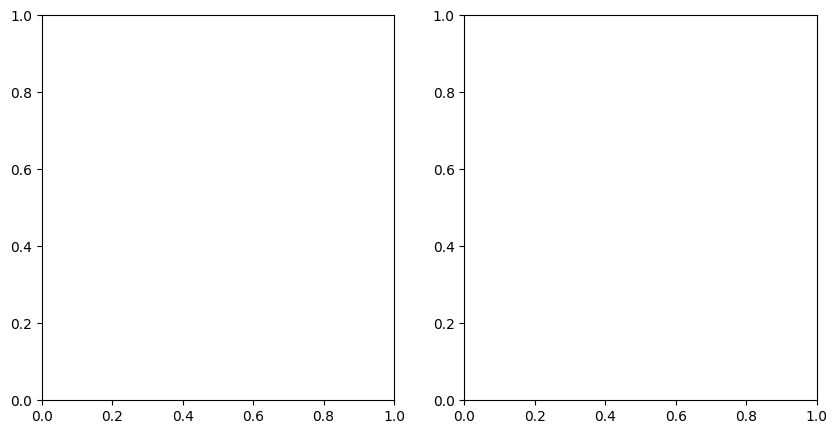

In [71]:
import matplotlib.pyplot as plt
# plot the ground truth and prediction belief histogram side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
time_idx = 22
episode = test_episodes[2]
axs[0].imshow(test_episodes[4]["discrete_belief"][time_idx].sum(-1))
axs[0].set_title("Ground Truth")
axs[1].imshow(test_episodes[4]["predicted_belief"][time_idx].sum(-1))
axs[1].set_title("Prediction")
plt.show()


In [49]:
import cv2


def visualize_trajectory_step(env, episode, step_idx):
    """
    Visualize a single step showing true and predicted belief distributions side by side
    """
    # Get true and predicted belief grids
    # We remove the last dimension as it is the angle dimension
    true_grid = episode['discrete_belief'][step_idx].sum(-1)
    pred_grid = episode['predicted_belief'][step_idx].sum(-1)

    # Normalize grids to 0-255 range
    true_grid = (((true_grid - true_grid.min()) / (true_grid.max() - true_grid.min())) * 255).astype(np.uint8)
    pred_grid = (((pred_grid - pred_grid.min()) / (pred_grid.max() - pred_grid.min())) * 255).astype(np.uint8)
    # Make y coordinates to be negative 
    true_grid = np.flip(true_grid, axis=1).T
    pred_grid = np.flip(pred_grid, axis=1).T
    
    render_size = (256, 256)
    # resize the grids to match the image size
    true_grid = cv2.resize(true_grid, render_size)
    pred_grid = cv2.resize(pred_grid, render_size)
    
    # Create two backgrounds
    env.render_size = render_size  # Increased size for better visibility
    true_img = env._create_background()
    pred_img = true_img.copy()
    h, w = true_img.shape[:2]
    
    # Convert belief grids to heatmaps
    true_heatmap = cv2.applyColorMap(
        (true_grid * 255).astype(np.uint8), 
        cv2.COLORMAP_JET
    )
    pred_heatmap = cv2.applyColorMap(
        (pred_grid * 255).astype(np.uint8), 
        cv2.COLORMAP_JET
    )
    
    # Blend heatmaps with background
    alpha = 0.33
    true_vis = cv2.addWeighted(true_img, 1-alpha, true_heatmap, alpha, 0)
    pred_vis = cv2.addWeighted(pred_img, 1-alpha, pred_heatmap, alpha, 0)
    
    # Draw path and current position
    path = episode['state'][:step_idx+1, :2]
    current_state = episode['state'][step_idx]
    path_pixels = env._world_to_pixel(path)
    pos_pixel = env._world_to_pixel(current_state[:2])
    
    # Draw path
    for img in [true_vis, pred_vis]:
        cv2.polylines(img, [path_pixels.astype(np.int32)], False, (0, 0, 255), 2)
        # Draw current position as red circle
        cv2.circle(img, tuple(pos_pixel.astype(np.int32)), 5, (0, 0, 255), -1)
    
    # Stack images side by side
    combined = np.hstack([true_vis, pred_vis])
    
    # Add labels and colorbar
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(combined, "True Belief", (10, 30), font, 1, (255, 255, 255), 2)
    cv2.putText(combined, "Predicted Belief", (w + 10, 30), font, 1, (255, 255, 255), 2)
    
    # Add colorbar
    colorbar_h = 20
    colorbar = np.linspace(0, 255, w).astype(np.uint8)
    colorbar = cv2.applyColorMap(colorbar.reshape(1, -1), cv2.COLORMAP_JET)
    colorbar = cv2.resize(colorbar, (w*2, colorbar_h))
    
    # Add min/max labels to colorbar
    cv2.putText(colorbar, "0.0", (5, 15), font, 0.1, (255, 255, 255), 1)
    cv2.putText(colorbar, "1.0", (w*2-30, 15), font, 0.1, (255, 255, 255), 1)
    
    # Combine visualization with colorbar
    combined = np.vstack([combined, colorbar])
    
    return combined
episode = test_episodes[7]
frames = []
for i in range(len(episode['state'])):
    frame = visualize_trajectory_step(env, episode, step_idx=i)
    frames.append(frame)
    cv2.imshow('Trajectory Visualization', frame)
    cv2.waitKey(100)  # 50ms delay between frames
cv2.destroyAllWindows()

import imageio
imageio.mimsave('trajectory.gif', frames, fps=10)